In [1]:
import os
os.chdir('../')

In [29]:
from glob import glob

import pandas as pd
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda import amp
from torch.utils.data.sampler import SequentialSampler

import timm
from timm.models.resnet import resnet34d

import cv2
import matplotlib.pyplot as plt

In [3]:
print(timm.__version__)

0.8.6dev0


In [5]:
model = resnet34d(pretrained=True)
model

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet34d_ra2-f8dcfcaf.pth" to /home/giorgio/.cache/torch/hub/checkpoints/resnet34d_ra2-f8dcfcaf.pth


ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
   

In [10]:
#https://www.kaggle.com/code/hengck23/proprocess-function-e-g-crop-breast-region/data?select=preprocess.py

class PreprocessNet(nn.Module):

    def __init__(self) -> None:
        super().__init__()

        self.register_buffer('mean', torch.FloatTensor([0.5, 0.5, 0.5]).reshape(1,3,1,1))
        self.register_buffer('std', torch.FloatTensor([0.5, 0.5, 0.5]).reshape(1,3,1,1))

        self.encoder = resnet34d(pretrained=True)
        self.encoder.maxpool = nn.Identity()

        dim = 512

        self.mask = nn.Sequential(
            nn.Conv2d(dim,4*16, kernel_size = 3, padding=1),
            nn.PixelShuffle(2),
            nn.ReLU(True),
            nn.Conv2d(16,4, kernel_size = 3, padding=1),
            nn.PixelShuffle(2),
        )
        self.laterality = nn.Linear(dim,1)

    def forward(self, batch):
        x = batch['image']
        x = (x - self.mean) / self.std
        
        e = self.encoder.forward_features(x)
        mask = self.mask(e)
        mask = torch.sigmoid(mask)
        mask  = F.interpolate(mask,size=x.shape[-2:],mode='bilinear',align_corners=False)

        pool = F.adaptive_avg_pool2d(e,1)
        pool = torch.flatten(pool,1)
        laterality = self.laterality(pool).reshape(-1)
        laterality = torch.sigmoid(laterality)

        output={
            'mask':mask,
            'laterality':laterality,
        }
        return output

In [11]:
class PreprocessDataset(Dataset):
    def __init__(self, df, image_size=224):
        self.df = df
        self.length = len(df)
        self.image_size = image_size

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        d = self.df.iloc[index]

        image = np.zeros((self.image_size, self.image_size), np.uint8)
        m = cv2.imread(d.png_file, cv2.IMREAD_GRAYSCALE)
        h, w = m.shape

        s = self.image_size /h
        h, w = int(s * h), int(s * w)
        m = cv2.resize(m, dsize=(w, h), interpolation=cv2.INTER_LINEAR)
        y = (self.image_size - h) // 2
        x = (self.image_size - w) // 2
        rect = (x, y, x + w, y + h)

        image[y:y + h, x:x + w] = m
        image = image.astype(np.float32) / 255

        r = {}
        r['index'] = index
        r['d'    ] = d
        r['rect' ] = rect
        r['image'] = torch.from_numpy(image).float()
        return r

def proprocess_collate(batch):
    d = {}
    key = batch[0].keys()
    for k in key:
        v = [b[k] for b in batch]
        d[k] = v
    d['image'] = torch.stack(d['image'],0).unsqueeze(1)
    return d

In [13]:
def predict_to_mask(predict):

    #for image size 224
    erosion_size = 7
    min_diff = 224

    #----
    thresh = ((predict>0.5)*255).astype(np.uint8)
    contour, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)  # CHAIN_APPROX_NONE     CHAIN_APPROX_SIMPLE
    c = max(contour, key=cv2.contourArea)
    m0 = np.zeros(shape=thresh.shape, dtype=np.uint8)
    cv2.drawContours(m0, [c], -1, 255, thickness=-1)

    element = cv2.getStructuringElement( cv2.MORPH_ELLIPSE, (2 * erosion_size + 1, 2 * erosion_size + 1), (erosion_size, erosion_size))
    m1 = cv2.erode(m0, element)
    contour, hierarchy = cv2.findContours(m1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)  # CHAIN_APPROX_NONE     CHAIN_APPROX_SIMPLE
    c = max(contour, key=cv2.contourArea)
    m1[...]=0
    cv2.drawContours(m1, [c], -1, 255, thickness=-1)

    m2 = cv2.dilate(m1, element)

    ##----------
    ss = (m0 == m2).sum()
    if ss < min_diff:
        mask = m0
    else:
        mask = m2

    mask = mask/255
    return mask

def mask_to_box(mask, pad=0.03):
    yy, xx = np.where(mask > 0)
    xmin = xx.min()
    xmax = xx.max()
    ymin = yy.min()
    ymax = yy.max()

    h,w = mask.shape
    pad = int(pad*h)
    xmin = max(0, xmin - pad)
    xmax = min(w, xmax + pad)
    ymin = max(0, ymin - pad)
    ymax = min(h, ymax + pad)
    return xmin, ymin, xmax, ymax

In [14]:
def post_process(batch, output):
    rect  = batch['rect']
    image = [m for m in batch['image'].float().data.cpu().numpy().squeeze(1)]
    mask  = [p for p in output['mask'].float().data.cpu().numpy().squeeze(1)]
    laterality = (output['laterality'].float().data.cpu().numpy() > 0.5).astype(int).tolist()
    box = []

    batch_size = len(batch['index'])
    for b in range(batch_size):
        x0, y0, x1, y1 = rect[b]
        m = image[b][y0:y1, x0:x1]
        p = mask[b][y0:y1, x0:x1]

        h = y1-y0
        p = predict_to_mask(p)
        xmin, ymin, xmax, ymax = mask_to_box(p)
        box.append((xmin/h, ymin/h, xmax/h, ymax/h))
        image[b] = m
        mask[b] = p

    output = {
        'image' : image,
        'mask' : mask,
        'laterality' : laterality,
        'box' : box,
    }
    return output


In [30]:
#create some dummy images for demo
image_dir = f'/home/giorgio/Scrivania/kaggle/rnsa-mammo-kaggle/data/cut_off_image512x1024'

png_file = glob(f'{image_dir}/**/*.png',recursive=True)
df = pd.DataFrame({
    'png_file': png_file,
})
print(df)

dataset = PreprocessDataset(df)
loader = DataLoader(
    dataset,
    batch_size  = 8,
    sampler=SequentialSampler(dataset),
    drop_last   = False,
    num_workers = 0,
    pin_memory  = False,
    collate_fn = proprocess_collate,
)

                                                png_file
0      /home/giorgio/Scrivania/kaggle/rnsa-mammo-kagg...
1      /home/giorgio/Scrivania/kaggle/rnsa-mammo-kagg...
2      /home/giorgio/Scrivania/kaggle/rnsa-mammo-kagg...
3      /home/giorgio/Scrivania/kaggle/rnsa-mammo-kagg...
4      /home/giorgio/Scrivania/kaggle/rnsa-mammo-kagg...
...                                                  ...
54701  /home/giorgio/Scrivania/kaggle/rnsa-mammo-kagg...
54702  /home/giorgio/Scrivania/kaggle/rnsa-mammo-kagg...
54703  /home/giorgio/Scrivania/kaggle/rnsa-mammo-kagg...
54704  /home/giorgio/Scrivania/kaggle/rnsa-mammo-kagg...
54705  /home/giorgio/Scrivania/kaggle/rnsa-mammo-kagg...

[54706 rows x 1 columns]


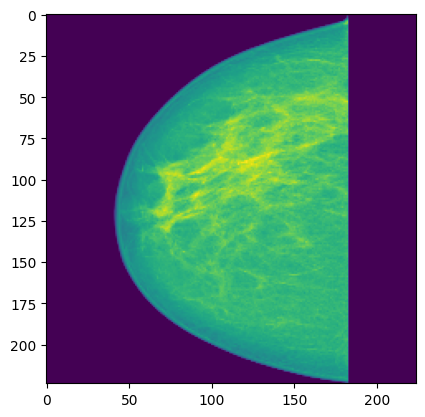

In [31]:
plt.imshow(dataset[0]['image'])

In [32]:
checkpoint = f'/home/giorgio/Scrivania/kaggle/rnsa-mammo-kaggle/data/00000387.model.pth'  

net = PreprocessNet()
f = torch.load(checkpoint, map_location=lambda storage, loc: storage)
net.load_state_dict(f['state_dict'],strict=True)
#net.cuda()
net.eval()
for t, batch in enumerate(loader):
    batch_size = len(batch['index'])
    for k in ['image']: 
        batch[k] = batch[k]#.cuda()

    with torch.no_grad():
        with amp.autocast(enabled = True):
            output = net(batch)

ValueError: could not broadcast input array from shape (224,244) into shape (224,10)